In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
import math
import numpy as np
from matplotlib.pyplot import figure
import seaborn as sns

# Import and then remove duplicates of all the cities
everything = pd.read_csv('worldcities.csv')
everything = everything.drop_duplicates(subset=['lat', 'lng'])
everything = everything.reset_index()

countries = everything.get('country')
cities = everything.get('city')

In [2]:
# Reorder data so that each country is a key and each city is in its value
length = len(everything)
ordered = {}

for i in range(length):
    if countries[i] in ordered:
        ordered[countries[i]].append(cities[i])
    else:
        ordered[countries[i]] = [cities[i]]

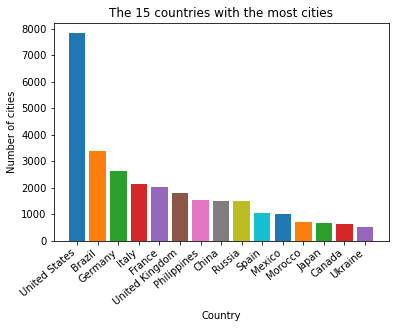

In [3]:
#orders the cities by number of cities and plots a bar chat
ordered = OrderedDict(sorted(ordered.items(), key = lambda x: len(x[1]), reverse=True))
maxlen = len(list(ordered.items())[0][1])

for i in range(15):
    tot = len(list(ordered.items())[i][1])
    plt.bar(list(ordered.items())[i][0], tot)

plt.xticks(rotation=40, ha='right')
plt.xlabel('Country')
plt.ylabel('Number of cities')
plt.title('The 15 countries with the most cities')
plt.show()

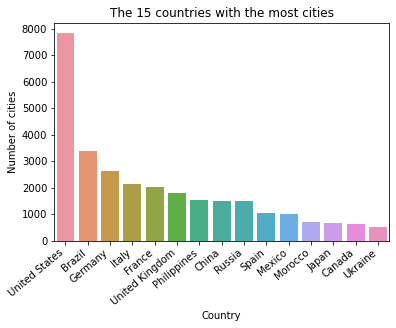

In [4]:
#Same as above graph without reordering data
ax = sns.countplot(x="country", data=everything, order=everything.country.value_counts().iloc[:15].index)
plt.xticks(rotation=40, ha='right')
plt.xlabel('Country')
plt.ylabel('Number of cities')
plt.title('The 15 countries with the most cities')
plt.show()

In [5]:
# Makes all keys have the same number of values and saves as a CSV
for city in ordered.items():
    for i in range(maxlen - len(city[1])):
        city[1].append(' ')

ordered = pd.DataFrame(ordered)
ordered.to_csv('new_cities.csv', index=False)

In [6]:
print(pd.read_csv('new_cities.csv'))

         United States          Brazil    Germany    Italy     France  \
0             New York       São Paulo     Berlin     Rome      Paris   
1          Los Angeles  Rio de Janeiro    Hamburg    Milan       Nice   
2              Chicago  Belo Horizonte     Munich   Naples   Toulouse   
3                Miami        Brasília    Cologne    Turin  Marseille   
4               Dallas        Salvador  Frankfurt  Palermo     Rennes   
...                ...             ...        ...      ...        ...   
7818         Ridgeland                                                  
7819            Dwight                                                  
7820  Oak Park Heights                                                  
7821         Gillespie                                                  
7822          Midfield                                                  

     United Kingdom    Philippines      China            Russia      Spain  \
0            London         Manila   Shanghai

In [7]:
#Finds the distance between two locations along the surface of the globe
def coord2dist(lat1, long1, lat2, long2):
    R = 6371
    φ1 = lat1 * math.pi/180
    φ2 = lat2 * math.pi/180
    Δφ = (lat2-lat1) * math.pi/180
    Δλ = (long2-long1) * math.pi/180

    
    a = np.sin(Δφ/2) * np.sin(Δφ/2) + np.cos(φ1) * np.cos(φ2) * np.sin(Δλ/2) * np.sin(Δλ/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    return(R * c)

In [8]:
#Finds a quick distance on a 2D plane
def dist(lat1, lat2, long1, long2):
    lat = lat1-lat2
    long = long1-long2
    long = (180-abs(abs(long)-180))
    return(lat*lat+long*long)

In [9]:
#Plots points taking into account going off the 'side' of the map
def plot(x1, x2, y1, y2):
    if abs(x1-x2)<180:
        plt.plot([x1, x2], [y1, y2], linewidth=0.5)
    elif x1>x2:
        plt.plot([x1, x2+360], [y1, y2], linewidth=0.5)
        plt.plot([x1-360, x2], [y1, y2], linewidth=0.5)
    else:
        plt.plot([x1+360, x2], [y1, y2], linewidth=0.5)
        plt.plot([x1, x2-360], [y1, y2], linewidth=0.5)

In [10]:
#Draws the map on the plot
def addmap():
    plt.xlim(-180, 180)
    plt.ylim(-90,90)
    img = plt.imread("worldmap.png")
    plt.imshow(img, extent=[-180, 180, -90, 90])

1000


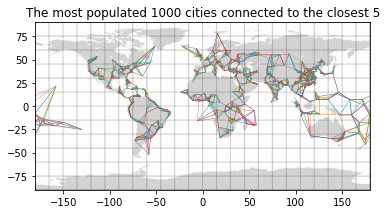

In [11]:
#Finds and plots the closest 5 cities for the most populated countries (takes too long to do them all)
numcity = 1000
reduced = everything.head(numcity)
redlen = numcity

lats = np.array(reduced.get('lat'))
longs = np.array(reduced.get('lng'))
city = reduced.get('city')

close = {}

for j in range(numcity):
    closest = np.column_stack((range(numcity), dist(lats, lats[j], longs, longs[j])))
    closest = closest[closest[:,1].argsort()]
    closest = closest[1:,:]
    copy = 0
    
    if city[j]+str(0) in close:
        finish = False
        i=1
        while finish == False:
            if city[j]+str(i) in close:
                i+=1
            else:
                finish = True
        copy+=1      

    close[(city[j]+str(copy)).title()] = [[city[closest[1][0]], ("%.2f" % coord2dist(lats[int(closest[1][0])], longs[int(closest[1][0])], lats[j], longs[j]))]]
    for i in range(2,6):
        close[(city[j]+str(copy)).title()].append([city[closest[i][0]], ("%.2f" % coord2dist(lats[int(closest[i][0])], longs[int(closest[i][0])], lats[j], longs[j]))])
    
    for i in range(5):
        plot(longs[j], longs[int(closest[i][0])], lats[j], lats[int(closest[i][0])])
        
    if not(j%1000):
        print(numcity - j)


addmap()
plt.title('The most populated ' + str(numcity) + ' cities connected to the closest 5')
plt.savefig('connectedworld.png', dpi=400)

In [12]:
#Gets the user to input a city and lists the 5 closest ones
name = input("Which city would you like to check? ").title()

if name not in set(reduced['city']):
    finish = False
    while finish == False:
        name = input("Please enter a valid city: ").title()
        if name in set(reduced['city']):
            finish = True
            
options = reduced.loc[reduced['city'] == name]
if len(options) > 1:
    print('Which ' + name + ' did you want? ')
    for i in range(len(options)):
        print(str(i+1) + '. ' + list(options['city'])[i] + ', ' + list(options['admin_name'])[i] + ', ' + list(options['country'])[i])
    choice = input('Enter which number: ')
    try:
        choice = int(choice) - 1
    except ValueError:
        choice=choice
    if choice not in range(len(options)):
        finish = False
        while finish == False:
            choice = input('Please enter a valid number: ')
            try:
                choice = int(choice) - 1
            except ValueError:
                choice=choice
            if choice in range(len(options)):
                finish = True
else:
    choice = 0

print('The closest cities to ' + list(options['city'])[choice] + ', ' + list(options['admin_name'])[choice] + ', ' + list(options['country'])[choice] + ' are:')
for res in close.get(name + str(choice)):
    print('{}{}'.format(res[0].ljust(15), 'which is ' + res[1] + 'km away'))

Which city would you like to check? london
The closest cities to London, London, City of, United Kingdom are:
Southampton    which is 111.43km away
Birstall       which is 146.35km away
Birmingham     which is 162.69km away
Leeds          which is 272.34km away
Manchester     which is 261.98km away


In [13]:
#Quicker solution below
#Plots a minimum spanning tree for the most populated countries (takes too long to do them all)

#numcity = 1000
#reduced = everything.head(numcity)

# lats = np.array(reduced.get('lat'))
# longs = np.array(reduced.get('lng'))

# close = {}
# tree = np.array([[0,0,0]])
# treeedge = [0]
# current = 0

# for j in range(numcity-1):
#     temp = []
#     for i in [x for x in range(numcity) if x not in treeedge]:
#         temp.append([current, i, dist(lats[i], lats[current], longs[i], longs[current])])
#     tree = np.concatenate((tree, temp))
#     tree = tree[tree[:,2].argsort()]
    
#     if j == 0:
#         tree = tree[1:, :]
    
#     current = int(tree[0][1])
#     treeedge.append(current)
#     plot(longs[int(tree[0][0])], longs[current], lats[int(tree[0][0])], lats[current])
#     tree = np.delete(tree, np.where(tree[:,1]==current)[0], axis = 0)
    
#     if not(j%100):
#         print(numcity - j)

# addmap()
# plt.title('A minimum spanning tree of the most populated ' + str(numcity) + ' cities')
# plt.savefig('minconnectedalt.png', dpi=400)

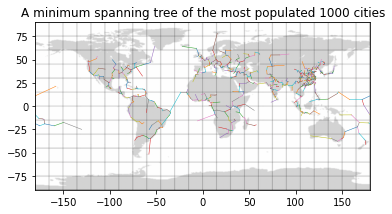

In [14]:
#Plots a minimum spanning tree for the most populated countries

numcity = 1000
reduced = everything.head(numcity)

lats = np.array(reduced.get('lat'))
longs = np.array(reduced.get('lng'))

close = {}
tree = []
whichtree = []
inwhich = list(range(numcity))
edgelist=[[-1]]*numcity

for j in range(numcity):
    for i in np.array(range(numcity-j-1))+j+1:
        tree.append([j, i, dist(lats[i], lats[j], longs[i], longs[j])])
    whichtree.append([j])
    
tree=np.array(tree)
tree = tree[tree[:,2].argsort()]

i = 0
count = 0
while count < numcity-1:
    op1 = int(tree[i][0])
    op2 = int(tree[i][1])
    which1 = inwhich[op1]
    which2 = inwhich[op2]
    if op1 not in whichtree[which2]:
        whichtree[which2] = whichtree[which2] + whichtree[which1]
        temp=inwhich[op1]
        for j in whichtree[inwhich[op1]]:
            inwhich[j] = inwhich[op2]
        whichtree[temp] = []
        
        plot(longs[op1], longs[op2], lats[op1], lats[op2])
            
        count+=1
        edgelist[op1] = edgelist[op1] + [op2]
        edgelist[op2] = edgelist[op2] + [op1]

    i+=1   

addmap()
plt.title('A minimum spanning tree of the most populated ' + str(numcity) + ' cities')
plt.savefig('minconnected.png', dpi=400)

In [15]:
# #Plots a Hamiltonian Cycle for the most populated countries (takes too long to do them all)
# # uses the edges found above to find a cycle by moving to the next available vertex until it reaches a leaf and then connecting that to the previous branch that was skipped

# done = [-1, 0]
# previous = -1
# current = 0

# for i in range(2*(numcity-1)):
#     nex = [x for x in edgelist[current] if x not in done]
#     try: nex = nex[0]
#     except: 
#         nex = edgelist[current][1]

#     edgelist[current].remove(nex)
#     done = done + [nex]
#     previous = current
#     current = nex

# done = list(dict.fromkeys(done[1:]))
# for i in range(numcity):
#     plot(longs[done[i-1]], longs[done[i]], lats[done[i-1]], lats[done[i]])

# addmap()
# plt.title('A Hamiltonian cycle of the most populated ' + str(numcity) + ' cities')
# plt.savefig('worldcycle.png', dpi=400)

In [16]:
# #An alternative Hamiltonian cycle method
# #Plots a Hamiltonian Cycle for the most populated countries (takes too long to do them all)
# #Cycles through all possilbe starting points to find a minimum cycle using the previous method

# numcity = 1000
# reduced = everything.head(numcity)

# lats = np.array(reduced.get('lat'))
# longs = np.array(reduced.get('lng'))

# close = {}
# minim = float('inf')
# vertexlist=[]
# diffmat= []
# poss = []
# for i in range(numcity):
#     diffmat.append([])
#     poss.append([])

# for j in range(numcity):
#     for i in np.array(range(numcity-j))+j:
#         diffmat[i].append([j, dist(lats[i], lats[j], longs[i], longs[j])])
#         if i != j:
#             diffmat[j].append([i, dist(lats[i], lats[j], longs[i], longs[j])])
#     temp = np.array(diffmat[j])
#     poss[j] = temp[temp[:,1].argsort()]

# count = 0
# for i in range(numcity):
#     distance = 0
#     used = [i]
#     j=0
#     current = i
#     while j < numcity-1 and distance<minim:
#         finish = False
#         k=0
#         while finish == False:
#             if poss[current][k][0] in used:
#                 k += 1
#             else:
#                 current = int(poss[current][k][0])
#                 distance += poss[current][k][1]
#                 finish = True
#                 used.append(current)
#         j += 1
#     distance += diffmat[i][current][1]
#     if distance < minim:
#         minim = distance
#         vertexlist = used
    
#     if not(i%100):
#          print(numcity - i)

# for i in range(numcity):
#     plot(longs[vertexlist[i-1]], longs[vertexlist[i]], lats[vertexlist[i-1]], lats[vertexlist[i]])
# addmap()
# plt.title('A minimum Hamiltonian cycle of the most populated ' + str(numcity) + ' cities')
# plt.savefig('worldcyclealt.png', dpi=400)

In [17]:
def check(done, branch):
    best = float('inf')
    
    for i in range(len(done)):
        distance = dist(longs[done[i-1]], longs[branch[0]], lats[done[i-1]], lats[branch[0]])
        distance += dist(longs[branch[-1]], longs[done[i]], lats[branch[-1]], lats[done[i]])
        if distance < best:
            res = i
            best = distance
    return(res)

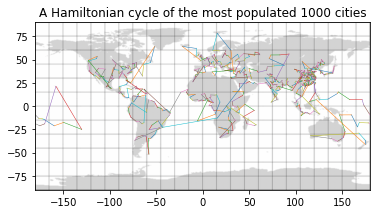

In [18]:
#Plots a Hamiltonian Cycle for the most populated countries 
#Breaking the minimum tree into branches which are checked against all possible possitions in the tree currently created to see where is best to add it

numcity = 1000
reduced = everything.head(numcity)

global lats 
lats = np.array(reduced.get('lat'))
global longs 
longs= np.array(reduced.get('lng'))

close = {}
tree = []
whichtree = []
inwhich = list(range(numcity))
edgelist=[[-1]]*numcity

for j in range(numcity):
    for i in np.array(range(numcity-j-1))+j+1:
        tree.append([j, i, dist(lats[i], lats[j], longs[i], longs[j])])
    whichtree.append([j])
    
tree=np.array(tree)
tree = tree[tree[:,2].argsort()]

i = 0
count = 0
while count < numcity-1:
    op1 = int(tree[i][0])
    op2 = int(tree[i][1])
    which1 = inwhich[op1]
    which2 = inwhich[op2]
    if op1 not in whichtree[which2]:
        whichtree[which2] = whichtree[which2] + whichtree[which1]
        temp=inwhich[op1]
        for j in whichtree[inwhich[op1]]:
            inwhich[j] = inwhich[op2]
        whichtree[temp] = []
            
        count+=1
        edgelist[op1] = edgelist[op1] + [op2]
        edgelist[op2] = edgelist[op2] + [op1]
    i+=1   


done = [-1, 0]
current = 0
repeat = []
count = 0

branch = []

while len(done)<numcity+1:
    nex = [x for x in edgelist[current] if x not in done + branch]
    if nex != []:
        if len(nex) > 1:
            repeat.append(current)
            
        nex = nex[0]
        branch += [nex]
        
        current = nex
    else: 
        if count != 0:
            pos = check(done, branch)
            done = done[:pos+1] + branch + done[pos+1:]
        else:
            done += branch
        branch = []
        if len(done) < numcity+1:
            current = repeat[count]
            count += 1
        

done = done[1:]
distance = 0
for i in range(numcity):
    plot(longs[done[i-1]], longs[done[i]], lats[done[i-1]], lats[done[i]])
    distance += dist(longs[done[i-1]], longs[done[i]], lats[done[i-1]], lats[done[i]])

addmap()
plt.title('A Hamiltonian cycle of the most populated ' + str(numcity) + ' cities')
plt.savefig('bestworldcycle.png', dpi=400)

In [19]:
# #Plots a minimum spanning tree for the most populated countries 
# #Organises the edges from shortest to longest before adding them one at a time ensuring the vertices are only drawn twice.

# numcity = 1000
# reduced = everything.head(numcity)

# lats = np.array(reduced.get('lat'))
# longs = np.array(reduced.get('lng'))

# tree = []
# for i in range(numcity):
#     tree.append([])
# pos = np.zeros(numcity)
# current = []
# done = []
# done2 = []
# whichtree = []
# inwhich = list(range(numcity))

# for j in range(numcity):
#     for i in np.array(range(numcity-j-1))+j+1:
#         tree[j].append([i, dist(lats[i], lats[j], longs[i], longs[j])])
#         tree[i].append([j, dist(lats[i], lats[j], longs[i], longs[j])])
#     whichtree.append([j])
    
# tree=np.array(tree)
# for j in range(numcity):
#     tree[j] = tree[j][tree[j][:,1].argsort()]
#     current.append([j, tree[j][0][0], tree[j][0][1]])

# current = np.array(current)

# while len(done2) < numcity-2:
#     temp = current[(current[:,2]).argsort()]
#     v1 = int(temp[0][0])
#     v2 = int(temp[0][1])
    
#     if v1 in done2:
#         current[v1] = [v1, tree[v1][i][0], float('inf')]
#     else:
#         which1 = inwhich[v1]
#         which2 = inwhich[v2]
#         if v1 not in whichtree[which2]:
#             whichtree[which2] = whichtree[which2] + whichtree[which1]
#             temp=inwhich[v1]
#             for j in whichtree[inwhich[v1]]:
#                 inwhich[j] = inwhich[v2]
#             whichtree[temp] = []
        
#             if v1 not in done:
#                 done.append(v1)
#             else:
#                 done2.append(v1)

#             if v2 not in done:
#                 done.append(v2)
#             else:
#                 done2.append(v2)
            
#             plot(longs[v1], longs[v2], lats[v1], lats[v2])
            
            
#         finish = True
#         i=int(pos[v1])+1
#         while finish:
#             if tree[v1][i][0] not in done2:
#                 finish = False
#                 current[v1] = [v1, tree[v1][i][0], tree[v1][i][1]]
#                 pos[v1] = i
#             i+=1
        
#         if current[v2][1] == v1:
#             finish = True
#             i=int(pos[v2])+1
#             while finish:
#                 if tree[v2][i][0] not in done2:
#                     finish = False
#                     current[v2] = [v2, tree[v2][i][0], tree[v2][i][1]]
#                     pos[v2] = i
#                 i+=1

#         if len(done2)<numcity-2:
#             for j in [x for x in range(numcity) if x not in done2]:
#                 if current[j][1] in done2 or current[j][1] in whichtree[inwhich[j]]:
#                     finish = True
#                     i=int(pos[j])+1
#                     while finish:
#                         if tree[j][i][0] not in done2:
#                             finish = False
#                             current[j] = [j, tree[j][i][0], tree[j][i][1]]
#                             pos[j] = i
#                         i+=1
             
# x = [x for x in range(numcity) if x not in done2]
# plot(longs[x[0]], longs[x[1]], lats[x[0]], lats[x[1]])
    
# addmap()
# plt.title('A Hamiltonian cycle of the most populated ' + str(numcity) + ' cities')
# plt.savefig('worldcycle3.png', dpi=400)

In [20]:
continent = pd.read_csv('continents.csv')
everything2 = pd.merge(everything, continent, left_on='iso3',right_on='Three_Letter_Country_Code', how='left')
everything2 = everything2.drop_duplicates(subset=['city'], keep='last')

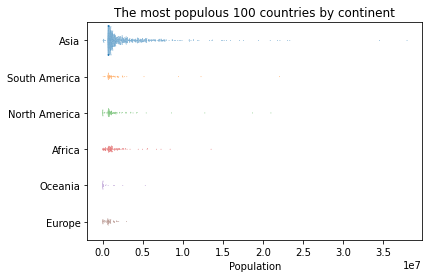

In [21]:
sns.swarmplot(x="population", y="Continent_Name", size=0.7, data=everything2[:1000])
ax.legend_ = None
plt.xlabel('Population')
plt.ylabel('')
plt.title('The most populous 100 countries by continent')
plt.show()

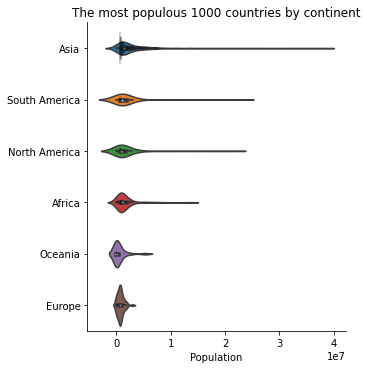

In [22]:
sns.catplot(x="population", y="Continent_Name",kind="violin", data=everything2[:1000])
sns.swarmplot(x="population", y="Continent_Name",color="k", size=0.5, data=everything2[:1000])

plt.xlabel('Population')
plt.ylabel('')
plt.title('The most populous 1000 countries by continent')
plt.show()

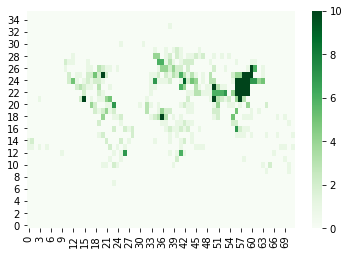

In [23]:
numcity = 1000
nearest = 5
int(360/5)
heat = np.zeros((int(180/nearest), int(360/nearest)))

for i in range(numcity):
    lat = round(everything['lat'][i]/nearest) + int(90/nearest)-1
    long = round(everything['lng'][i]/nearest) + int(180/nearest)-1
    heat[lat][long] += 1
    
sns.heatmap(heat, vmin=0, vmax=10, cmap="Greens")
plt.gca().invert_yaxis()

In [24]:
print(len(heat))

36


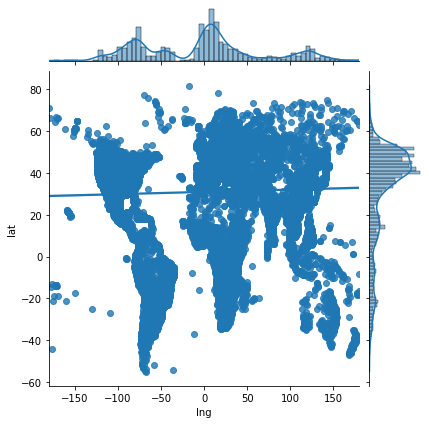

In [25]:
sns.jointplot(x="lng", y="lat", data=everything, kind='reg');

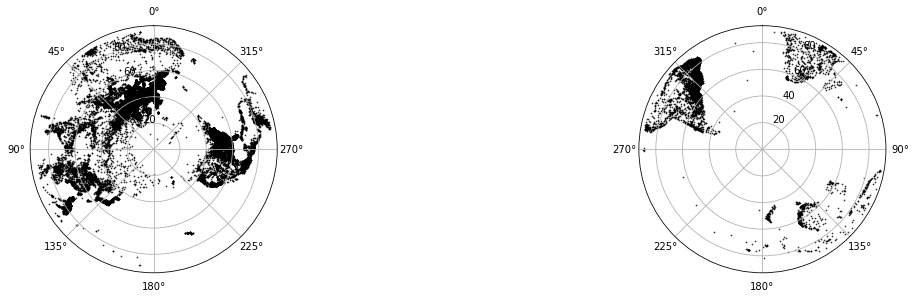

In [28]:
fig = plt.figure(figsize=(40,10))
data = everything

ax1 = fig.add_subplot(221, projection='polar')
data = everything[everything['lat']>0]
ax1.scatter(np.pi*(data['lng'])/180, 90-data['lat'], cmap='hsv', alpha=0.75, c='black', s=0.5)
ax1.set_theta_zero_location("N")

ax2 = fig.add_subplot(211, projection='polar')
data = everything[everything['lat']<0]
ax2.scatter(np.pi*(data['lng'])/180, 90+data['lat'], cmap='hsv', alpha=0.75, c='black', s=0.5)
ax2.set_theta_zero_location("N")
ax2.set_theta_direction(-1)

plt.show()

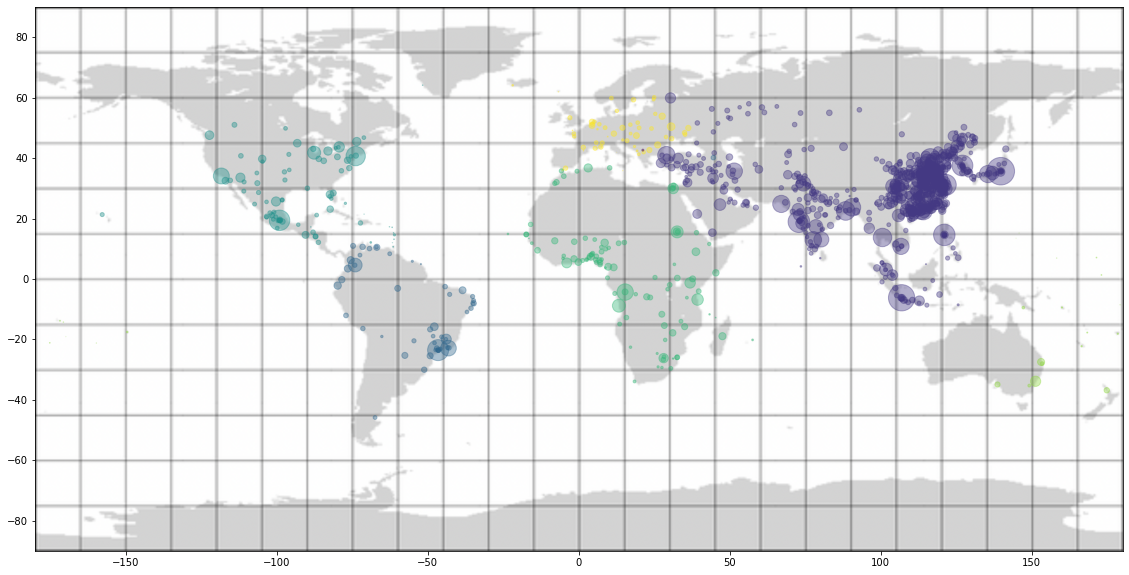

In [27]:
plt.figure(figsize=(40,10))
addmap()

data = everything2[:1000]

colour = pd.factorize(data['Continent_Name'])[0]

plt.scatter(
    x=data['lng'], 
    y=data['lat'], 
    s=data['population']/50000, 
    alpha=0.4, 
    c = colour
)
plt.show()